# Basic KAN DeepONet (style)

Now trying switching out the MLPs for KANs.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import pandas as pd

In [3]:
N_SAMPLES = 32
EPOCHS = 2000
LR = 1e-2

## Damped harmonic oscillator

This should be something nice and simple I can train on.

In [4]:
def f(t, ζ, ω0):
    return 1 - np.exp(-t * ζ * ω0) * np.cos(ω0 * np.sqrt(1 - ζ**2) * t + np.arccos(ζ)) / np.sin(np.arccos(ζ))


def get_rand_ζ():
    return np.random.rand() * 0.2 + 0.3


def get_rand_ω0():
    return np.random.rand() * 10 * np.pi * 0.2 + 10

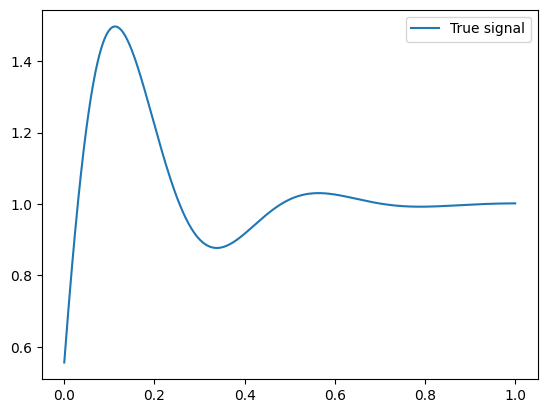

In [5]:
# ζ = 0.15
# ω0 = 10 * np.pi

ζ = get_rand_ζ()
ω0 = get_rand_ω0()

x = np.linspace(0, 1, 1000)
y = f(x, ζ, ω0)

fig, ax = plt.subplots()

ax.plot(x, y, label="True signal")
_ = ax.legend()

## KAN

Following some of the tips [here](https://github.com/KindXiaoming/pykan/tree/master?tab=readme-ov-file#advice-on-hyperparameter-tuning).

### Data

In [6]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader


class ONetData(Dataset):
    def __init__(self, N=1000, n_samples=N_SAMPLES, test=False):
        self.N = N
        self.n_samples = n_samples
        self.x_sensor = np.linspace(0, 1, self.n_samples)
        self.test = test

    def __len__(self):
        return self.N

    def __getitem__(self, _):
        ζ = get_rand_ζ()
        ω0 = get_rand_ω0()
        y = np.random.rand()
        uy = f(y, ζ, ω0)
        params = torch.tensor([ζ, ω0], dtype=torch.float32)
        y = torch.tensor([y], dtype=torch.float32)
        uy = torch.tensor([uy], dtype=torch.float32)
        return params, y, uy

In [7]:
train_dset = ONetData(N=1000)
valid_dset = ONetData(N=1000)

train_dl = DataLoader(train_dset, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_dset, batch_size=64, shuffle=False)

In [8]:
pb, yb, uyb = next(iter(train_dl))
pb.shape, yb.shape, uyb.shape

(torch.Size([64, 2]), torch.Size([64, 1]), torch.Size([64, 1]))

### Model

In [9]:
from kan import KAN

In [10]:
class KANONet(nn.Module):
    def __init__(self):
        super().__init__()
        self.solution_network = KAN(width=[3, 4, 1, 1], grid=10, k=3, seed=0, device="cpu")

    def forward(self, params, y):
        x = torch.cat([params, y], dim=1)
        return self.solution_network(x)

In [11]:
model = KANONet()

In [12]:
pb, yb, uyb = next(iter(train_dl))

with torch.no_grad():
    out = model(pb, yb)

out.shape

torch.Size([64, 1])

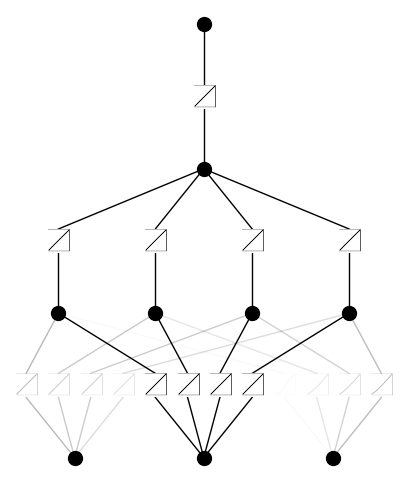

In [13]:
model.solution_network.plot()

## Training

In [14]:
from torch.optim.lr_scheduler import OneCycleLR

In [15]:
model = KANONet()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = OneCycleLR(optimizer, max_lr=LR, total_steps=EPOCHS * len(train_dl))
step = -1
ldf = pd.DataFrame(columns=["train_loss", "valid_loss"])
for epoch in range(EPOCHS):
    # model.train()
    for ux, y, uy in train_dl:
        step += 1
        row = {}
        optimizer.zero_grad()
        uy_pred = model(ux, y)
        loss = criterion(uy_pred, uy)
        loss.backward()
        optimizer.step()
        scheduler.step()
        row["train_loss"] = loss.item()
        ldf.loc[step] = row

    # model.eval()
    with torch.no_grad():
        losses = []
        for ux, y, uy in valid_dl:
            uy_pred = model(ux, y)
            loss = criterion(uy_pred, uy)
            losses.append(loss.item())
        valid_loss = np.mean(losses)
        ldf.loc[step, "valid_loss"] = valid_loss
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: {valid_loss}")

Epoch 0: 85.40463495254517
Epoch 10: 32.69412088394165
Epoch 20: 12.281135261058807
Epoch 30: 3.6763838827610016
Epoch 40: 0.7641464918851852
Epoch 50: 0.24057458247989416
Epoch 60: 0.09488227358087897
Epoch 70: 0.05337286996655166
Epoch 80: 0.034544407622888684
Epoch 90: 0.02855883998563513
Epoch 100: 0.02086982794571668
Epoch 110: 0.016086950607132167
Epoch 120: 0.013843935535987839
Epoch 130: 0.011310647387290373
Epoch 140: 0.010557225410593674
Epoch 150: 0.009588686458300799
Epoch 160: 0.006755076814442873
Epoch 170: 0.006504944059997797
Epoch 180: 0.0059723697195295244
Epoch 190: 0.006271594611462206
Epoch 200: 0.0053961045341566205
Epoch 210: 0.005737706203944981
Epoch 220: 0.005372453073505312
Epoch 230: 0.004855952152865939
Epoch 240: 0.005072840678622015
Epoch 250: 0.00435402434959542
Epoch 260: 0.004689255831181072
Epoch 270: 0.0073370905593037605
Epoch 280: 0.004810786442249082
Epoch 290: 0.005199509323574603
Epoch 300: 0.0053570130112348124
Epoch 310: 0.004720533892395906
E

In [22]:
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")

Number of parameters: 550


## Results

In [16]:
def plot_loss(ldf):
    fig, ax = plt.subplots()
    ax.plot(ldf["train_loss"], label="Train loss", lw=0.1)
    ax.plot(ldf["valid_loss"].interpolate(), label="Valid loss", lw=0.8)
    ax.legend()
    ax.set_yscale("log")

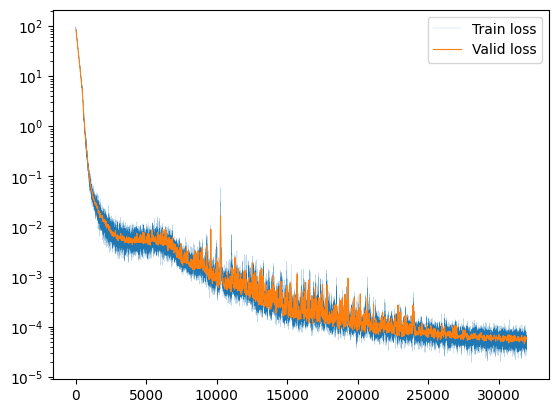

In [17]:
plot_loss(ldf)

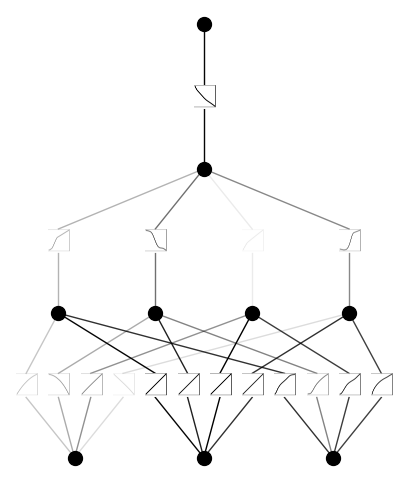

In [18]:
model.solution_network.plot()

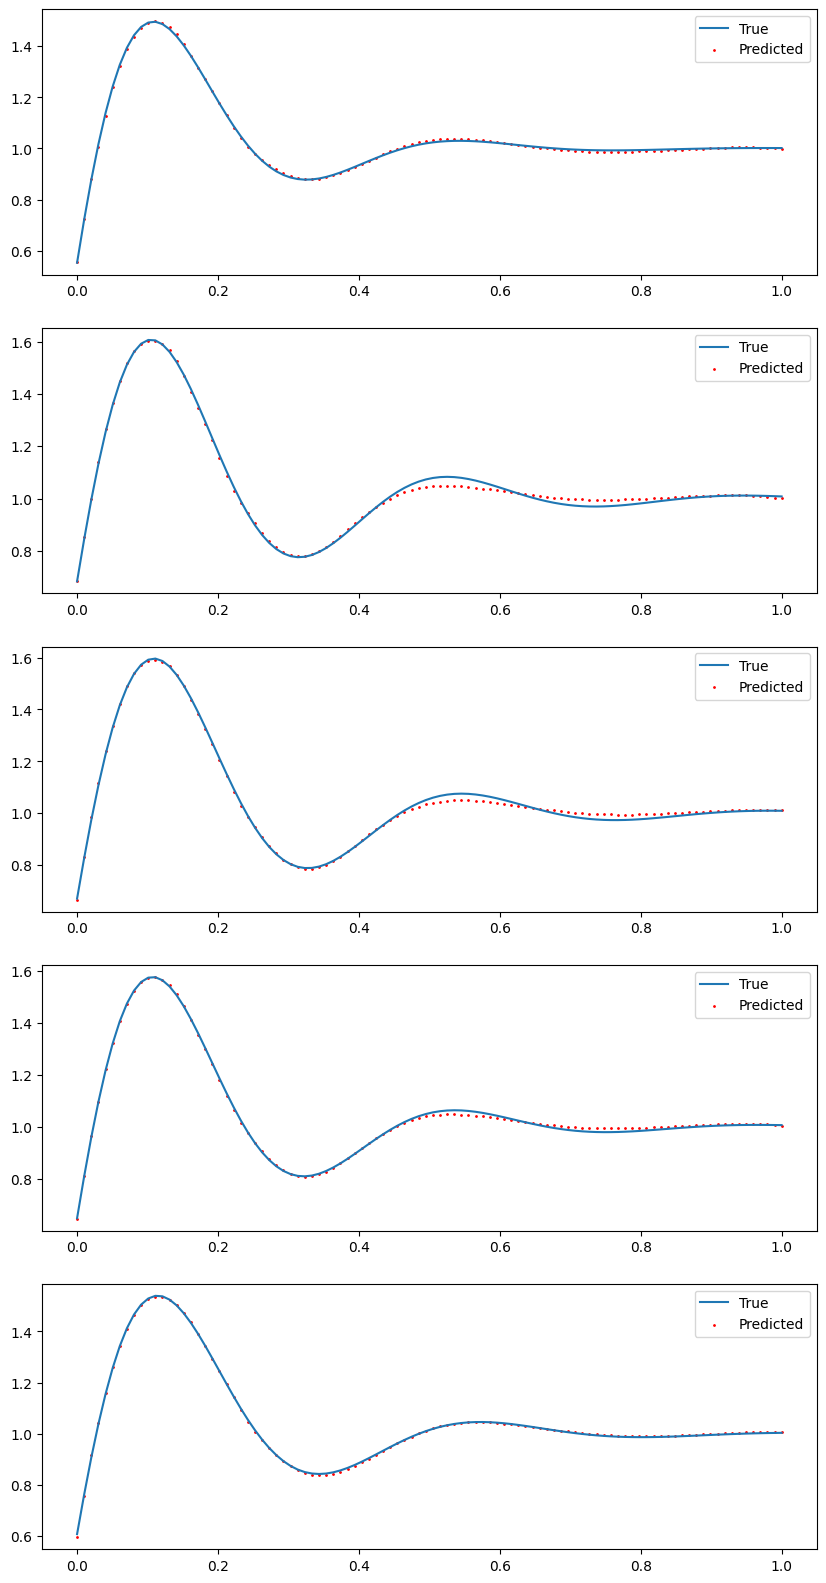

In [19]:
uy_preds = []
uy_trues = []
for i in range(5):
    params, y, uy = valid_dset[i]
    ζ, ω0 = params[0].item(), params[1].item()

    yb = np.linspace(0, 1, 100)[..., None]
    uyb = f(yb, ζ, ω0)

    paramsb = params[None].repeat(100, 1)

    yb = torch.tensor(yb, dtype=torch.float32)
    uyb = torch.tensor(uyb, dtype=torch.float32)

    with torch.inference_mode():
        uy_pred = model(paramsb, yb)

    uy_preds.append(uy_pred)
    uy_trues.append(uyb)

fig, axes = plt.subplots(5, 1, figsize=(10, 20))

for i, (uy_pred, uy_true) in enumerate(zip(uy_preds, uy_trues)):
    ax = axes[i]
    ax.plot(yb.flatten(), uy_true, label="True")
    ax.scatter(yb.flatten(), uy_pred, label="Predicted", color="r", s=1)
    ax.legend()

Look at the variance in the predictions to see how well it's capturing the spread of solutions:

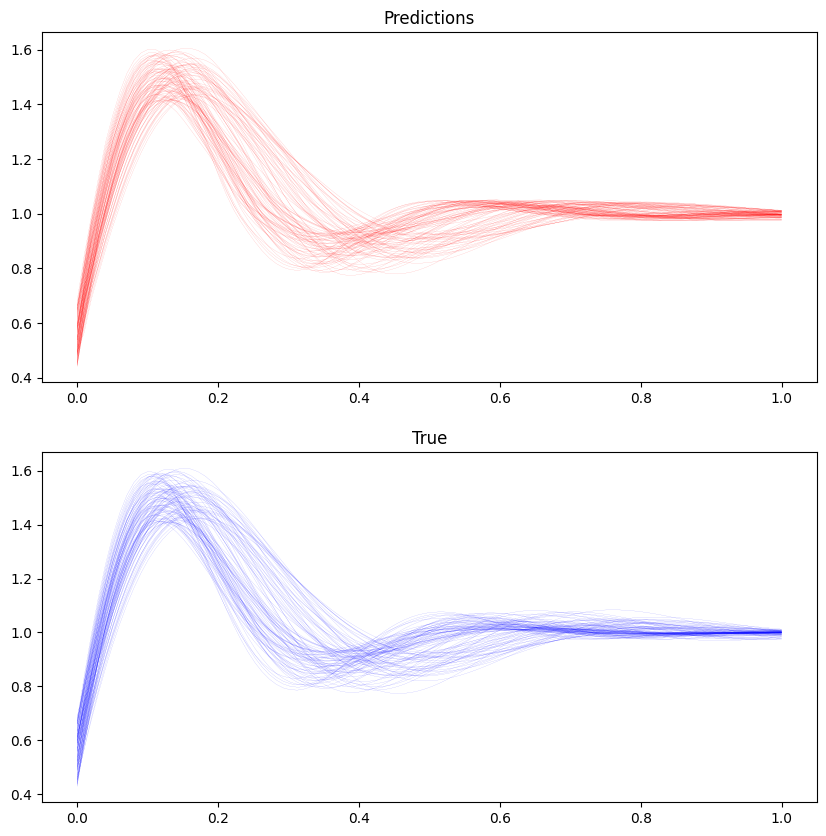

In [20]:
uy_preds = []
uybs = []
for i in range(100):
    params, y, uy = valid_dset[i]  # i doesn't really matter here but hey

    yb = np.linspace(0, 1, 100)[..., None]
    uyb = f(yb, params[0].item(), params[1].item())

    paramsb = params[None].repeat(100, 1)

    yb = torch.tensor(yb, dtype=torch.float32)
    uyb = torch.tensor(uyb, dtype=torch.float32)

    with torch.inference_mode():
        uy_pred = model(paramsb, yb)

    uy_preds.append(uy_pred)
    uybs.append(uyb)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

for uy_pred in uy_preds:
    axes[0].plot(yb.flatten(), uy_pred, color="r", lw=0.05)
    axes[0].set_title("Predictions")

for uyb in uybs:
    axes[1].set_title("True")
    axes[1].plot(yb.flatten(), uyb, color="b", lw=0.05)